In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from google.colab import drive
import networkx as nx
import copy



device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
        print('and then re-execute this cell.')
    else:
        print(gpu_info)
print('device :',device)
print('torch.version :',torch.__version__)

device : cpu
torch.version : 1.7.0+cu101


In [30]:
drive.mount('/content/drive')
folder_dir = '/content/drive/My Drive/cora'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
class Cora(object):
    
    def __init__(self, base_dir):
        data = np.genfromtxt(base_dir + '/cora/cora.content', dtype=np.str)
        

        self.category_list = list(set(data[:, -1]))
        self.cat2lab = {category:label for label, category in enumerate(self.category_list)}
        self.lab2cat = {label:category for label, category in enumerate(self.category_list)}
        
        self.paper_list = np.array(data[:, 0], dtype=np.int)
        self.paper2node = {paper_id:node_id for node_id, paper_id in enumerate(self.paper_list)}
        self.node2paper = {node_id:paper_id for node_id, paper_id in enumerate(self.paper_list)}


        self.node_feature = np.array(data[:, 1:-1], dtype=int)
        self.node_label = [self.cat2lab[category] for category in data[:, -1]]
        
        edge = np.genfromtxt(base_dir + '/cora/cora.cites',   dtype=np.int)
        self.node_connection = np.empty_like(edge)
        self.node_adj = np.zeros((data.shape[0], data.shape[0]), dtype=np.int)

        for i, (cited, citing) in enumerate(edge):
            self.node_connection[i] = (self.paper2node[cited], self.paper2node[citing])
            self.node_adj[self.node_connection[i][0]][self.node_connection[i][1]] = 1
            


    def get_dataset(self):

        node_x = np.array(self.node_feature, dtype=np.int32)
        node_y = np.array(self.node_label, dtype=np.int32)
        adjmat = np.array(self.node_adj, dtype=np.int32)
        return node_x, node_y, adjmat
        

cora = Cora(base_dir='/content/drive/My Drive')




node_x, node_y, adjmat = cora.get_dataset()



In [32]:
def undirected_adj_torch_bool(adjmat):
    
    undirected_adj_bool = torch.from_numpy(adjmat).bool()
    undirected_adj_bool = undirected_adj_bool + undirected_adj_bool.transpose(0, 1)
    return undirected_adj_bool



G = undirected_adj_torch_bool(adjmat)

In [33]:
class Embeder(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, dropout_p=0):
        super().__init__()
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        # self.dropout = nn.Dropout(dropout_p)
        self.tologits = nn.Linear(embedding_dim, num_embeddings, bias=False)


    def forward(self, index):
        emb = self.embedding(index)
        # emb = self.dropout(emb)
        return self.tologits(emb)


In [35]:
# def deep_walk(G, embedding_size, window_size, walk_length, num_epochs):

def deep_walk(G, embedding_dims,  walk_length, window_size, num_epochs, learning_rate):


    num_nodes = G.size(0) 
    model = Embeder(num_nodes, embedding_dims)
    solver = optim.Adam(model.parameters(), learning_rate)

    
    for epoch in range(num_epochs):

        start_list = torch.randperm(num_nodes)


        epoch_loss = 0.0
        for i in range(num_nodes):
            walk = [start_list[i]]

            for t in range(walk_length):
                neighs = G[walk[-1]]
                neigh_idx = torch.where(neighs == True)[0]
                selected_node = neigh_idx[torch.randint(low=0, high=len(neigh_idx), size=(1, ))][0]
                walk.append(selected_node)
            
            
            for j in range(walk_length):
                for k in range(j - window_size, j + window_size + 1):
                    if k >= 0 and k < walk_length:
                        solver.zero_grad()
                        logits = model(walk[j])     
                        loss = F.cross_entropy(logits.view(1, -1), walk[k].view(1))
                        loss.backward()
                        epoch_loss += loss.item()
                        solver.step()

        print(epoch_loss / num_nodes)
    return model



model = deep_walk(G, 2, 16, 3, 20, 0.005)

714.414114413461
668.422282982403
655.5661107979253
649.7986963253022
646.2886330428281
641.7364303737857
641.0317555630863
640.6120224791734
637.7705152462976
639.2995395818766
634.9193199581881
634.9776291229392
636.2662223701199
634.3802783100631
637.6931320017801
636.0013699657455
634.9709345065057
631.9350832902181
633.6961464555314
637.3959848294517


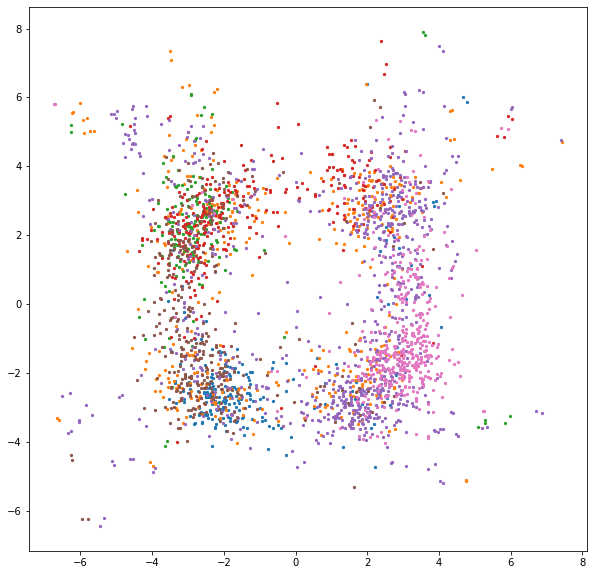

In [37]:
labels = np.array(cora.node_label)
# print(labels)

embs = model.embedding.weight.detach().numpy()
plt.figure(figsize=(10, 10))
for i in range(7):
    node_list = labels == i
    plt.scatter(embs[node_list, 0], embs[node_list, 1], s=5)
plt.show()
